In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip cache purge

!pip install torch==2.5.1 torchvision==0.20.1+cu124 -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

- Here taking module which are compatible to finbert model.

# Libraries

In [2]:
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Dataset Loading, Preprocessing, and Splitting

In [3]:
df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', header=None)
df.columns = ['sentiment', 'text']
df.dropna(inplace=True)

label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label2id)

# Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df[['text', 'label']])
hf_dataset = hf_dataset.train_test_split(test_size=0.2)

# Tokenization of Dataset Using FinBERT Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/970 [00:00<?, ? examples/s]

# Loading the FinBERT Model for Sequence Classification

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

# Setting Up Training Arguments for Fine-Tuning

In [6]:
training_args = TrainingArguments(
    output_dir="./finbert-finetuned",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

# Initializing the Trainer for Model Fine-Tuning

In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer
)

<ipython-input-7-eca663cc33b8>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
trainer.train()

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Step,Training Loss
500,0.566500


TrainOutput(global_step=972, training_loss=0.338934066364304, metrics={'train_runtime': 196.9126, 'train_samples_per_second': 78.735, 'train_steps_per_second': 4.936, 'total_flos': 461973716617392.0, 'train_loss': 0.338934066364304, 'epoch': 4.0})

# Evaluating the Model and Generating Predictions


In [9]:
results = trainer.evaluate()
print("Evaluation results:")
for key, value in results.items():
    print(f"{key}: {value}")

# calculating predictions on test set
predictions = trainer.predict(tokenized_datasets["test"])
preds = predictions.predictions.argmax(-1)

print("Classification report on Test data")
print(classification_report(tokenized_datasets["test"]["label"], preds,
                            target_names=["negative", "neutral", "positive"]))


Evaluation results:
eval_loss: 0.6462458968162537
eval_runtime: 3.3138
eval_samples_per_second: 292.715
eval_steps_per_second: 18.408
epoch: 4.0
Classification report on Test data
              precision    recall  f1-score   support

    negative       0.75      0.84      0.80       120
     neutral       0.90      0.86      0.88       586
    positive       0.78      0.83      0.80       264

    accuracy                           0.85       970
   macro avg       0.81      0.84      0.83       970
weighted avg       0.85      0.85      0.85       970



# Saving the Fine-Tuned Model and Tokenizer

In [10]:
trainer.save_model("./my-finbert-finetuned")
tokenizer.save_pretrained("./my-finbert-finetuned")


('./my-finbert-finetuned/tokenizer_config.json',
 './my-finbert-finetuned/special_tokens_map.json',
 './my-finbert-finetuned/vocab.txt',
 './my-finbert-finetuned/added_tokens.json',
 './my-finbert-finetuned/tokenizer.json')

# Manual testing for News headline


In [11]:
model = AutoModelForSequenceClassification.from_pretrained("./my-finbert-finetuned")
tokenizer = AutoTokenizer.from_pretrained("./my-finbert-finetuned")


In [12]:
finbert_custom = pipeline("text-classification", model="./my-finbert-finetuned", tokenizer=tokenizer)
finbert_custom("The company's quarterly loss exceeded expectations, driving the stock price higher.")

Device set to use cuda:0


[{'label': 'positive', 'score': 0.999764621257782}]

# Confusion Matrix for Model Evaluation

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


<Figure size 600x500 with 0 Axes>

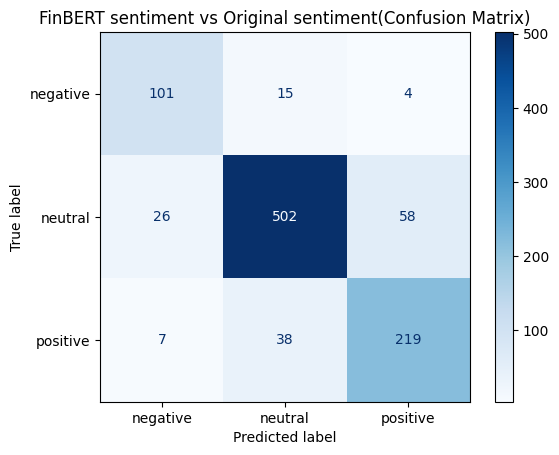

In [13]:
finbert_custom = pipeline(
    "text-classification",
    model="./my-finbert-finetuned",
    tokenizer=tokenizer,
    device=0
)

test_df = tokenized_datasets["test"].to_pandas()
def get_custom_sentiment(text):
    try:
        result = finbert_custom(text[:512])
        return result[0]["label"].lower()
    except:
        return "neutral"

test_df["finbert_sentiment"] = test_df["text"].apply(get_custom_sentiment)

label_map = {"negative": 0, "neutral": 1, "positive": 2}
y_true = test_df["label"]
y_pred = test_df["finbert_sentiment"].map(label_map)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("FinBERT sentiment vs Original sentiment(Confusion Matrix)")
plt.grid(False)
plt.show()


# To download Fine-tuned model on local pc

In [14]:
!zip -r my-finbert-finetuned.zip ./my-finbert-finetuned


  adding: my-finbert-finetuned/ (stored 0%)
  adding: my-finbert-finetuned/tokenizer_config.json (deflated 74%)
  adding: my-finbert-finetuned/model.safetensors (deflated 7%)
  adding: my-finbert-finetuned/special_tokens_map.json (deflated 42%)
  adding: my-finbert-finetuned/config.json (deflated 52%)
  adding: my-finbert-finetuned/training_args.bin (deflated 52%)
  adding: my-finbert-finetuned/vocab.txt (deflated 50%)
  adding: my-finbert-finetuned/tokenizer.json (deflated 70%)


In [15]:
from google.colab import files
files.download("my-finbert-finetuned.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>